In [25]:
import json
import numpy as np
import pandas as pd
import unidecode
import string
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Softmax
from keras.metrics import mean_squared_error

In [26]:
f = open('data/test.json')
data_test = json.load(f)
f.close()
f = open('data/train.json')
data_train = json.load(f)
f.close()

In [29]:
# Creating the target dataset y
y = [i['cuisine'] for i in data_train]
y = pd.DataFrame(y,columns=['Cuisine'])

# Printing how many datapoints we have corresponding to each cuisine
count = 1
for j in set(y.Cuisine):
    print('%i Cuisine: %s'%(count,j))
    count+= 1
    print('Occurrence: %i'%list(y.Cuisine).count(j))
    print('\n')

1 Cuisine: moroccan
Occurrence: 821


2 Cuisine: southern_us
Occurrence: 4320


3 Cuisine: russian
Occurrence: 489


4 Cuisine: filipino
Occurrence: 755


5 Cuisine: vietnamese
Occurrence: 825


6 Cuisine: french
Occurrence: 2646


7 Cuisine: mexican
Occurrence: 6438


8 Cuisine: greek
Occurrence: 1175


9 Cuisine: korean
Occurrence: 830


10 Cuisine: british
Occurrence: 804


11 Cuisine: indian
Occurrence: 3003


12 Cuisine: japanese
Occurrence: 1423


13 Cuisine: irish
Occurrence: 667


14 Cuisine: jamaican
Occurrence: 526


15 Cuisine: brazilian
Occurrence: 467


16 Cuisine: spanish
Occurrence: 989


17 Cuisine: italian
Occurrence: 7838


18 Cuisine: chinese
Occurrence: 2673


19 Cuisine: thai
Occurrence: 1539


20 Cuisine: cajun_creole
Occurrence: 1546




In [30]:
# Creating y_dummies as 1-hot vector dataframe
y_dummies = pd.get_dummies(y)
y_dummies.head()

,Cuisine_brazilian,Cuisine_british,Cuisine_cajun_creole,Cuisine_chinese,Cuisine_filipino,Cuisine_french,Cuisine_greek,Cuisine_indian,Cuisine_irish,Cuisine_italian,Cuisine_jamaican,Cuisine_japanese,Cuisine_korean,Cuisine_mexican,Cuisine_moroccan,Cuisine_russian,Cuisine_southern_us,Cuisine_spanish,Cuisine_thai,Cuisine_vietnamese
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# Creating the word embedding model here. 
# Please note 'embedding_dimension' is a hyperparameter here.
# Please change it and experiment with it.
sentences = [i['ingredients'] for i in data_train]
embedding_dimension = 150
w2v = Word2Vec(sentences, min_count=3, vector_size = embedding_dimension)
word_vectors = w2v.wv

In [6]:
# Creating the training dataframe 'X'
Data = np.zeros((len(data_train),embedding_dimension))
for i in range(len(data_train)):
    for j in data_train[i]['ingredients']:
        try:
            Data[i]+= word_vectors[j]
        except:
            continue            
X = pd.DataFrame(Data)

In [9]:
Model = Sequential(
    [
        #Dense(50, input_dim=embedding_dimension, activation = 'relu', name='layer1',),
        Dense(20, activation= 'relu'),
        Softmax(1),
    ]
)
Model.compile(loss=mean_squared_error, optimizer= 'Adam')

In [10]:
X_norm = (X-X.mean())/X.std() # Normalizing the training data before feeding it into the model

history = Model.fit(X_norm,y_dummies, validation_split=.2, epochs=100, batch_size = 8)

Epoch 1/100
3978/3978 [==============================] - 5s 1ms/step - loss: 0.0271 - val_loss: 0.0255
Epoch 2/100
3978/3978 [==============================] - 4s 1ms/step - loss: 0.0252 - val_loss: 0.0249
Epoch 3/100
3978/3978 [==============================] - 4s 1ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 4/100
3978/3978 [==============================] - 4s 1ms/step - loss: 0.0245 - val_loss: 0.0245
Epoch 5/100
3978/3978 [==============================] - 4s 1ms/step - loss: 0.0243 - val_loss: 0.0243
Epoch 6/100
3978/3978 [==============================] - 5s 1ms/step - loss: 0.0242 - val_loss: 0.0245
Epoch 7/100
3978/3978 [==============================] - 4s 1ms/step - loss: 0.0241 - val_loss: 0.0242
Epoch 8/100
3978/3978 [==============================] - 4s 1ms/step - loss: 0.0240 - val_loss: 0.0242
Epoch 9/100
3978/3978 [==============================] - 4s 1ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 10/100
3978/3978 [==============================] - 4s 1ms/step - l

3978/3978 [==============================] - 6s 2ms/step - loss: 0.0226 - val_loss: 0.0231
Epoch 80/100
3978/3978 [==============================] - 5s 1ms/step - loss: 0.0227 - val_loss: 0.0231
Epoch 81/100
3978/3978 [==============================] - 5s 1ms/step - loss: 0.0226 - val_loss: 0.0235
Epoch 82/100
3978/3978 [==============================] - 5s 1ms/step - loss: 0.0227 - val_loss: 0.0231
Epoch 83/100
3978/3978 [==============================] - 5s 1ms/step - loss: 0.0227 - val_loss: 0.0238
Epoch 84/100
3978/3978 [==============================] - 4s 984us/step - loss: 0.0226 - val_loss: 0.0229
Epoch 85/100
3978/3978 [==============================] - 5s 1ms/step - loss: 0.0226 - val_loss: 0.0235
Epoch 86/100
3978/3978 [==============================] - 5s 1ms/step - loss: 0.0226 - val_loss: 0.0229
Epoch 87/100
3978/3978 [==============================] - 5s 1ms/step - loss: 0.0226 - val_loss: 0.0231
Epoch 88/100
3978/3978 [==============================] - 5s 1ms/step - los

Text(0, 0.5, 'Mean Squared Error')

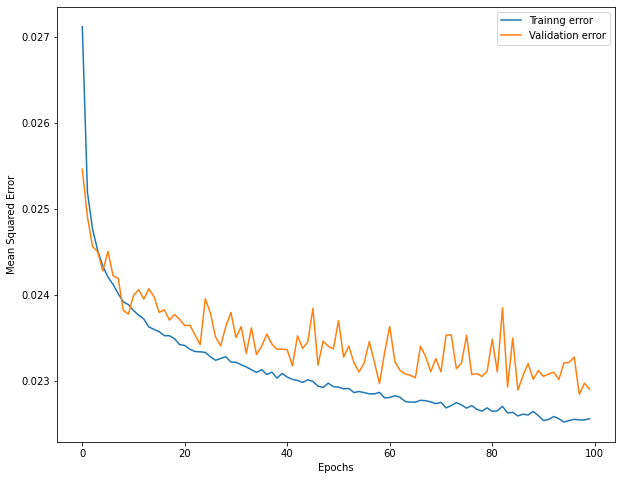

In [19]:
plt.figure(figsize = (10,8))
plt.plot(history.history['loss'], label = 'Trainng error')
plt.plot(history.history['val_loss'], label = 'Validation error')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')

In [17]:
Model.save('Model_1.H5')

INFO:tensorflow:Assets written to: Model_1.H5\assets


In [78]:
# Doing a performence check on first few data points
for i in range(50):
    print('Predicted Cuisine: %s'%y_dummies.columns[np.argmax(Model.predict(X_norm.to_numpy()[i:i+1]))].replace('Cuisine_',''))
    print('Actual Cuisine: %s'%y.loc[i].Cuisine)
    print('\n')

Predicted Cuisine: greek
Actual Cuisine: greek


Predicted Cuisine: southern_us
Actual Cuisine: southern_us


Predicted Cuisine: filipino
Actual Cuisine: filipino


Predicted Cuisine: indian
Actual Cuisine: indian


Predicted Cuisine: indian
Actual Cuisine: indian


Predicted Cuisine: southern_us
Actual Cuisine: jamaican


Predicted Cuisine: mexican
Actual Cuisine: spanish


Predicted Cuisine: southern_us
Actual Cuisine: italian


Predicted Cuisine: mexican
Actual Cuisine: mexican


Predicted Cuisine: italian
Actual Cuisine: italian


Predicted Cuisine: italian
Actual Cuisine: italian


Predicted Cuisine: chinese
Actual Cuisine: chinese


Predicted Cuisine: italian
Actual Cuisine: italian


Predicted Cuisine: mexican
Actual Cuisine: mexican


Predicted Cuisine: french
Actual Cuisine: italian


Predicted Cuisine: indian
Actual Cuisine: indian


Predicted Cuisine: italian
Actual Cuisine: british


Predicted Cuisine: italian
Actual Cuisine: italian


Predicted Cuisine: vietnamese
Actual C